# Approximate Nearest Neighbors:

# Image Recommendation System via Collaborative Filtering

# ***Please read the instructions very carefully***
This is a modified version of the previous question and requires you to use an artificial nearest neighbors library

We suggest you to use one of the following:
- [ScaNN](https://github.com/google-research/google-research/tree/master/scann)
- [FAISS](https://github.com/facebookresearch/faiss)
- [Annoy](https://github.com/spotify/annoy.git)

1.   Assignment must be implemented in Python 3 only.
2.   You are allowed to use libraries for data preprocessing (numpy, pandas, nltk etc) and for evaluation metrics, data visualization (matplotlib etc.).
3.   You will be evaluated not just on the overall performance of the model and also on the experimentation with hyper parameters, data prepossessing techniques etc.
4.   ⚠️ The Assignment will be evaluated automatically. Please adhere to taking proper inputs from `config.csv` file. You can change your `config.csv` file to experiment with your code. But at the end, make sure that your outputs are corresponding to input values in `config.csv`
5.   Strict plagiarism checking will be done. An F will be awarded for plagiarism.

## About the Dataset
Behance is a community art website where users showcase and discover creative work. Each user is able to “appreciate” (equivalent to a “like” on Instagram or a “react” on Facebook) an image, indicating that they like the image. It is in the website’s best interests to show users pictures that they would like, to keep them engaged for longer. For this question, given a set of pictures that a user has already appreciated, you have to show them a new picture that they would like based on what similar users appreciated.


<br><br>
**The dataset has information of 1 million appreciates of 63,497 users on 178,788 items. The file Behance appreciate 1M has a triplet in each line in the form of (user id, item id, unix timestamp).**

**Task: Take the inputs from the config.csv file and output the recommendations for a particular person**
- Collaborative Filtering is a way to predict items to the user based on the the
user’s history and the history of similar users. The similarity between users can be quantified by the number of images that both the users appreciated.
- The images appreciated by a similar user would be the most suitable images to show a user. Since we can find the similarity between any two users, we would be able to find the “nearest” neighbours of any user, allowing us to use a KNN-based algorithm to recommend new images to a user.
- Since people do not like seeing pictures that they have seen already. Make sure that you do not recommend pictures that a user has appreciated already.
- Output the final response will be saved in the file named ```config['output_file']```.


**Output file format:**
Populate the output file with images that the user has not seen of the k most
similar users, in descending order of their similarity. Each line in the output
file should be a duplet in the form of (item id, user id), where the user id is the
id of the kth similar user. The order of the images corresponding to the same
similar user would not matter. The output file would look something like this:
```
item_id_1_of_1st_similar_user 1st_most_similar_user_id
item_id_2_of_1st_similar_user 1st_most_similar_user_id
item_id_3_of_1st_similar_user 1st_most_similar_user_id
...
item_id_1_of_2nd_similar_user 2nd_most_similar_user_id
item_id_2_of_2nd_similar_user 2nd_most_similar_user_id
item_id_3_of_2nd_similar_user 2nd_most_similar_user_id
...
item_id_1_of_kth_similar_user kth_most_similar_user_id
item_id_2_of_kth_similar_user kth_most_similar_user_id
item_id_3_of_kth_similar_user kth_most_similar_user_id
```

You may use any other recommendation system that you wish to use. However,
evaluation script will score your submission by measuring the similarity between
users with the number of common images they appreciated.
The dataset was extracted using Behance’s API as a part of the paper
“Vista: A visually, socially, and temporally-aware model for artistic
recommendation, RecSys, 2016”. Check out this [Google Drive folder](https://drive.google.com/drive/folders/0B9Ck8jw-TZUEc3NlMjVXdDlPU1k?resourcekey=0-6_8ykn0o4fLc5fuTEm91xA) for
more information about the dataset.


Have fun! The users are waiting to see new pictures!

### Import necessary libraries

In [13]:
!pip install scann

In [14]:
import numpy as np
import pandas as pd
import scann
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
import random
import math

In [15]:
# Config Generation Sample Code.
# ⚠️ Only for experimentation on your side.
# ⚠️ Should be commented during submission.

# df = pd.DataFrame(data=[{'id':276633,
#                   'k':5,
#                   'dataset_file':'./Behance_appreciate_1M',
#                   'output_file':'./output.txt'}])
# df.to_csv('config.csv')

In [16]:
#REMOVE LATER
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/My Drive/smai/

In [17]:
config = pd.read_csv('config.csv').iloc[0]

In [18]:
config

Unnamed: 0                            0
id                               276633
k                                     5
dataset_file    ./Behance_appreciate_1M
output_file                ./output.txt
Name: 0, dtype: object

In [19]:
user_query = config['id']
k_value = config['k']

### Read the Data

In [20]:
with open(config['dataset_file'], 'r') as inFile:
    appreciate_data = inFile.readlines()

In [21]:
# your code here

In [22]:
appreciate_data

['276633 01588231 1307583271\n',
 '1238354 01529213 1307583273\n',
 '165550 00485000 1307583337\n',
 '2173258 00776972 1307583340\n',
 '165550 00158226 1307583406\n',
 '1238354 01540285 1307583495\n',
 '2459267 01578261 1307583509\n',
 '165550 00264669 1307583518\n',
 '165550 00171501 1307583536\n',
 '165550 00195913 1307583556\n',
 '3192280 00612915 1307583564\n',
 '1238354 01541385 1307583567\n',
 '82097 01534067 1307583582\n',
 '119968 00865826 1307583584\n',
 '3192280 00282175 1307583594\n',
 '165550 00399468 1307583612\n',
 '1238354 01547817 1307583624\n',
 '82097 01191427 1307583650\n',
 '82097 01194099 1307583654\n',
 '165550 00272413 1307583707\n',
 '1238354 01463635 1307583708\n',
 '16235 01555141 1307583757\n',
 '165550 00264576 1307583795\n',
 '165550 00164305 1307583811\n',
 '82097 01291783 1307583811\n',
 '82097 01283617 1307583816\n',
 '16235 00362825 1307583819\n',
 '3192280 01328071 1307583819\n',
 '82097 01278525 1307583821\n',
 '82097 01184273 1307583824\n',
 '165550 

### Initialize a dictionary to store the item_ids that a user likes

### Go through each line of the input file and construct the user_likes dictionary

In [23]:
user_likes = {}

In [24]:
users_total=0
users=[]
images=[]
for line in appreciate_data:
  line = line.strip()
  user_id = int(line.split()[0])
  item_id = int(line.split()[1])
  images.append(item_id)
  users.append(user_id)
  if user_id not in user_likes:
    user_likes[user_id] = list()
  users_total+=1
  user_likes[user_id].append(item_id)

In [25]:
items_dict=dict()
user_dict=dict()
index=0
for item in images:
  if item not in items_dict.keys():
    items_dict[item]=index
    index+=1
print(index)
index=0
for user in users:
  if user not in user_dict.keys():
    user_dict[user]=index
    index+=1
print(index)
users=set(users)
images=set(images)

178788
63497


In [26]:
images_total=len(images)
users_total=len(users)

In [27]:
print(users_total)
print(images_total)

63497
178788


In [28]:
user_indexes=[]
items_indexes=[]
data_values=[]
for user in user_likes.keys():
  for image in user_likes[user]:
    user_indexes.append(user_dict[user]),
    items_indexes.append(items_dict[image])
    data_values.append(1)

In [29]:
data=csr_matrix((data_values, (user_indexes, items_indexes)), shape=(users_total, images_total),dtype=np.int8)

In [30]:
print(data)

  (0, 0)	1
  (0, 72)	1
  (0, 73)	1
  (0, 74)	1
  (0, 261)	1
  (0, 276)	1
  (0, 368)	1
  (0, 375)	1
  (0, 390)	1
  (0, 757)	1
  (0, 1070)	1
  (0, 1095)	1
  (0, 1235)	1
  (0, 1292)	1
  (0, 1492)	1
  (0, 1558)	1
  (0, 1561)	1
  (0, 2042)	1
  (0, 2232)	1
  (0, 2266)	1
  (0, 2267)	1
  (0, 2300)	1
  (0, 2343)	1
  (0, 2891)	1
  (0, 2948)	1
  :	:
  (63483, 17647)	1
  (63484, 17647)	1
  (63485, 5182)	1
  (63485, 9783)	1
  (63486, 178760)	1
  (63487, 17647)	1
  (63487, 174603)	1
  (63488, 2879)	1
  (63489, 2500)	1
  (63489, 101038)	1
  (63489, 178786)	1
  (63490, 99109)	1
  (63490, 99114)	1
  (63490, 99115)	1
  (63490, 139078)	1
  (63491, 94060)	1
  (63491, 97757)	1
  (63492, 2609)	1
  (63492, 21064)	1
  (63493, 13582)	1
  (63494, 17647)	1
  (63495, 5698)	1
  (63495, 5704)	1
  (63496, 1266)	1
  (63496, 89097)	1


In [31]:
svd = TruncatedSVD(n_components=1000,random_state=17)
svd_data=svd.fit_transform(data)

In [32]:
normalized_dataset = svd_data / np.linalg.norm(svd_data, axis=1)[:, np.newaxis]

In [33]:
def jaccard_distance(user_x,user_y,data):
  inter=len(set(data[user_x]).intersection(data[user_y]))
  union=len(data[user_x])+len(data[user_y])-inter
  similarity_score=(float(inter)/union)
  return similarity_score
def simple_similarity(user_x,user_y,data):
  inter=len(set(data[user_x]).intersection(data[user_y]))
  return inter
def cosine_similarity(vector_a,vector_b):
  dot_product=np.dot(vector_a, vector_b)
  mag_a=np.linalg.norm(vector_a)
  mag_b=np.linalg.norm(vector_b)
  return (dot_product/float(mag_a*mag_b))

In [34]:
index_dict = {v: k for k, v in user_dict.items()}

In [35]:
searcher = scann.scann_ops_pybind.builder(normalized_dataset, 10, "dot_product").tree(
    num_leaves=int(math.sqrt(len(normalized_dataset))), num_leaves_to_search=100, training_sample_size=len(normalized_dataset)
    ).score_ah(2, anisotropic_quantization_threshold=0.2).reorder(100).build()

2022-04-14 19:40:43.595927: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 63497
2022-04-14 19:40:46.488239: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 2.891752991s.


### Use your choice of Approximate Nearest Neigbor after Collaborative Filtering to find nearest neighbors

In [36]:
# Finding distance using Jaccards similarity

# Finding the k nearest users of a user using item watching patterns
# list of tuples of distances and corresponding user attached
def neighbors(user,k_value):
  neighbors, distances = searcher.search(normalized_dataset[user_dict[user]], final_num_neighbors=k_value+20)
  counter=0
  top_k_users=[]
  seen_items=set(user_likes[user])
  for n in neighbors:
    if counter == k_value:
      break
    if len(set(user_likes[index_dict[n]]).intersection(seen_items)) < len(set(user_likes[index_dict[n]])):
      top_k_users.append(index_dict[n])
      counter+=1
  return top_k_users

In [37]:
neighbors(276633,5)

[2452817, 148706, 1525134, 3103074, 3308864]

### Answer the following questions:

#### Q1. **Explain how your choice of library works**

ScaNN (Scalable Nearest Neighbors) is a method for efficient vector similarity search at scale. SCANN deals with the quantization of the embeddings in the dataset unlike the usual method of directly quantizing the data points. It has been proven to perform better than most of the similarity search libraries by a factor of 2 for the same accuracy.


For example if we have two points d1 and d2 for which we have embeddings in the dataset, and our use case is to find the most similar vector to the test datapoint q. ScaNN will calculate their projections on the perpendicular vector to q. This way it reduces the latency and increases the accuracy of the similarity scores.

ScaNN performs in 3 phases:
1. Partitioning: ScaNN partitions the given dataset during training, and during test time selects the top partitions to pass onto the scoring stage. This is an optional stage
2. Scoring: ScaNN calculates the distances from the test data point to all datapoints in the dataset, if partitioning is not enabled or all datapoints in a partition to search, if partitioning is enabled. These distances are not as accurate as expected.
3. Rescoring: This is an optional stage and only happens if partioning is enabled.
ScaNN takes the d distances from scoring phase and calculates these distances again more accurately. From these d distances the top k are selected. 

#### Q2. **Compare your choice of library with vanilla KNN.**
***Hint: Include Time Complexity, and explain the tradeoff with recall***

Vanilla KNN has a huge cost to compute the nearest neighbours for larger datasets. The training time is O(1) and Testing time is O(k\*n\*d) where k is the number of neigbours, n is the size of training data set and d is the dimensionality of the vector i.e. the  number of features.
With increase in dimensionality the recall improves and K-NN becomes slow. So here there is a trade off between recall and computational time. Although this generally doesn't happen with ScaNN, it is much faster than the Vanilla KNN.

#### Q3. **Compare your choice of library with implementation of ScaNN, faiss and annoy.**


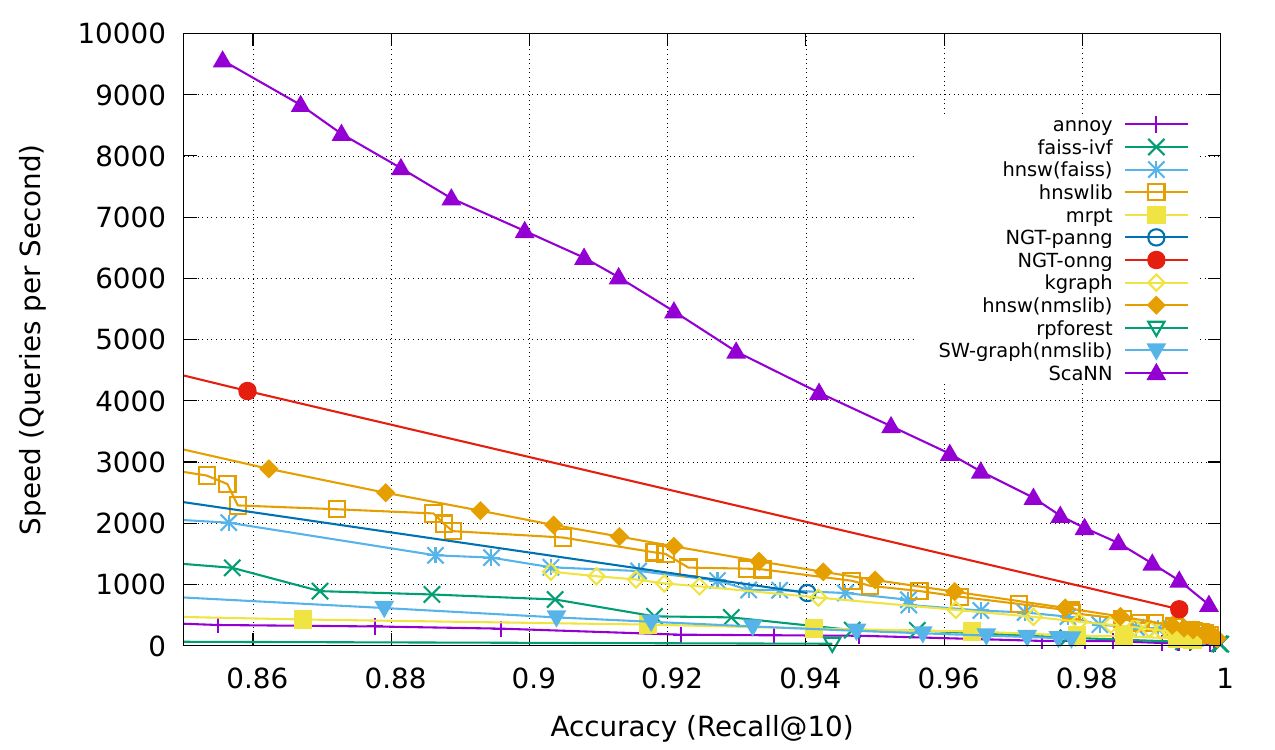

From the above graph we can see that SCANN is the best of the 3 libraries as it gives far more accuracy than the other libraries and with drop in accuracy its speed increases dramatically.

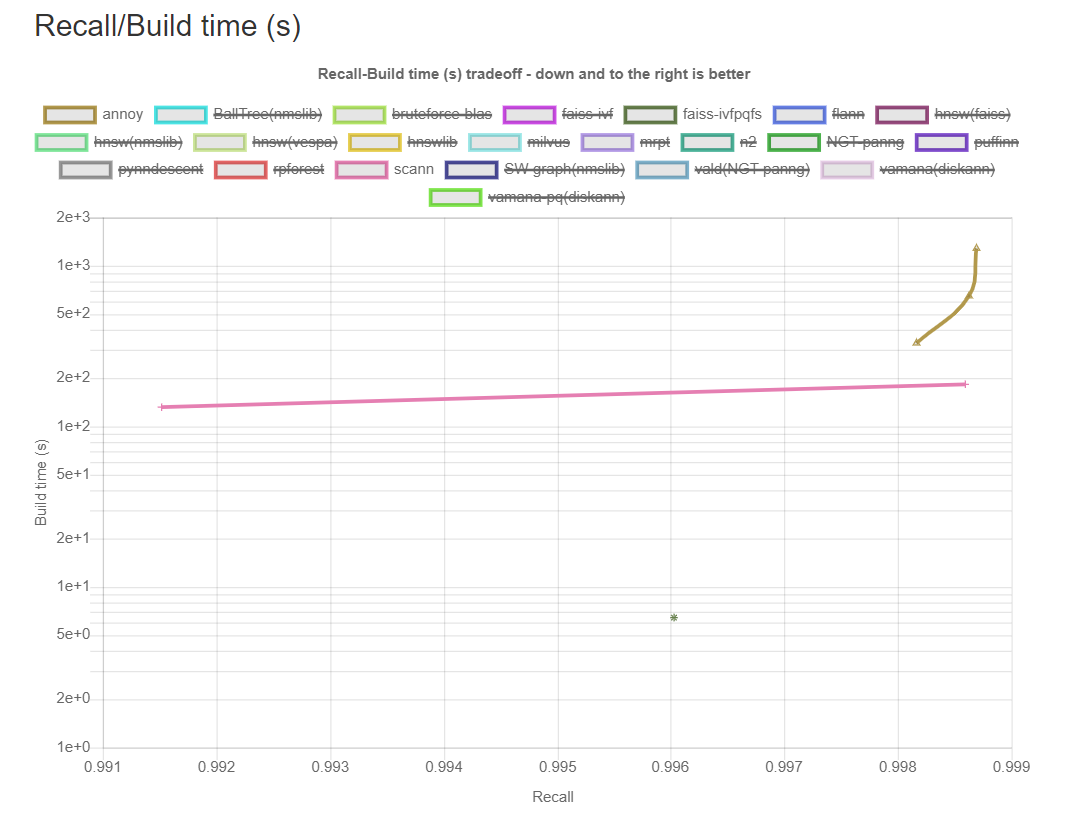

From the above graph it is clear that Faiss takes the least amount of build time to achieve a recall score of 0.996 wheras ScaNN takes relatively more but has far more recall score wheras annoy has highest build time and almost reaches 1

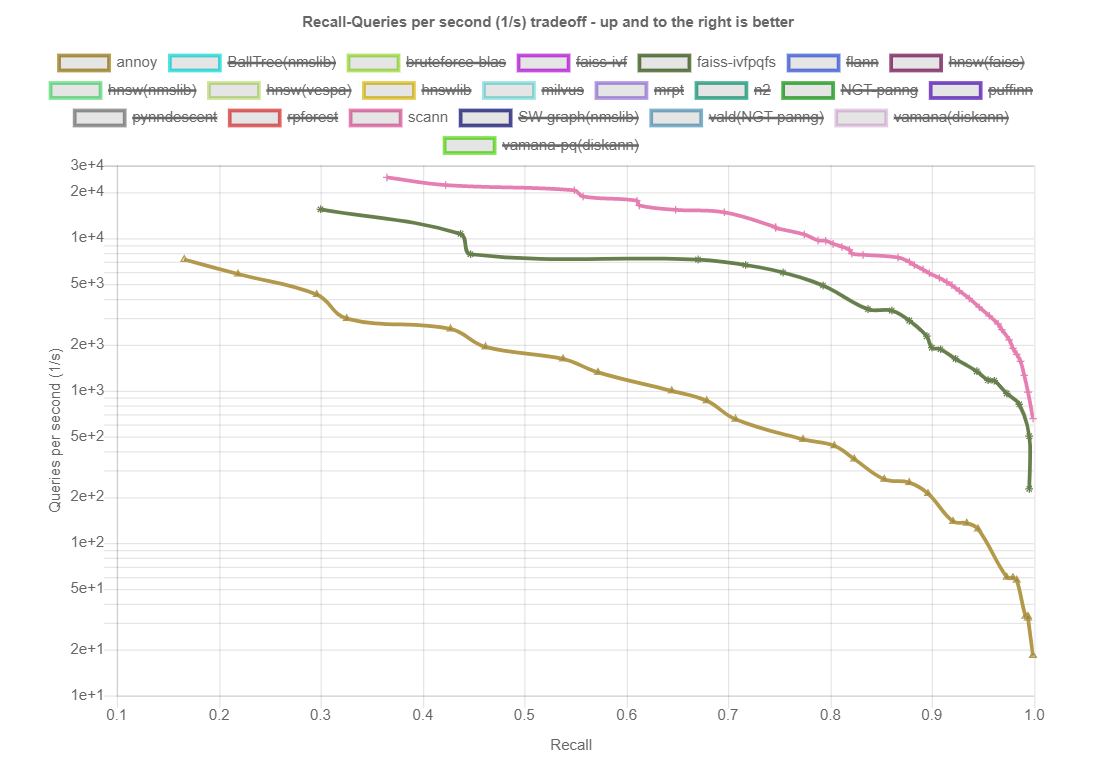

ScaNN has the highest queries per second, then there is Faiss and then Annoy and so we can conclude that ScaNN is better than the other two libraries.

References: 
* http://ann-benchmarks.com/glove-100-angular_10_angular.html
* https://github.com/google-research/google-research/tree/master/scann

### Open the output file to write all the lines to the file

In [26]:
outFile = open(config['output_file'], 'w')
seen_items=set(user_likes[user_query])
for n_user in neighbors(user_query,k_value):
    n_user_items=user_likes[n_user]
    for item_id in n_user_items:
      if item_id not in seen_items:
        outFile.write(str(item_id) + ' ' + str(n_user) + '\n')
    #seen_items=seen_items.union(set(n_user_items))
outFile.close()